# From Facebook

https://github.com/facebookresearch/mae/blob/main/demo/mae_visualize.ipynb

In [1]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./custom_mae/src')
else:
    sys.path.append('..')
module_dir = os.path.abspath('/projects/Cervical_Cancer_Projects/SSL/custom_mae/src/')
sys.path.append(module_dir)


import models_mae

/usr/local/lib/python3.8/dist-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


### Define utils

In [2]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

### Load an image

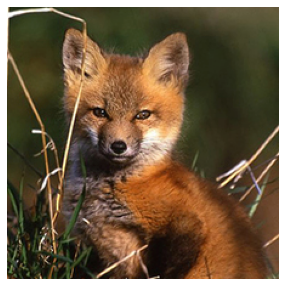

In [3]:
# load an image
img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img = Image.open(requests.get(img_url, stream=True).raw)
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

### Load a pre-trained MAE model

In [7]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_huge.pth

chkpt_dir = 'mae_visualize_vit_base.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_base_patch16')
print('Model loaded.')

--2023-09-11 22:08:03--  https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_huge.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.156.201.23, 108.156.201.112, 108.156.201.76, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.156.201.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2628481101 (2.4G) [binary/octet-stream]
Saving to: ‘mae_visualize_vit_huge.pth’

mae_visualize_vit_h 100%[===================>]   2.45G  17.7MB/s    in 2m 11s  

2023-09-11 22:10:14 (19.2 MB/s) - ‘mae_visualize_vit_huge.pth’ saved [2628481101/2628481101]

<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with pixel reconstruction:


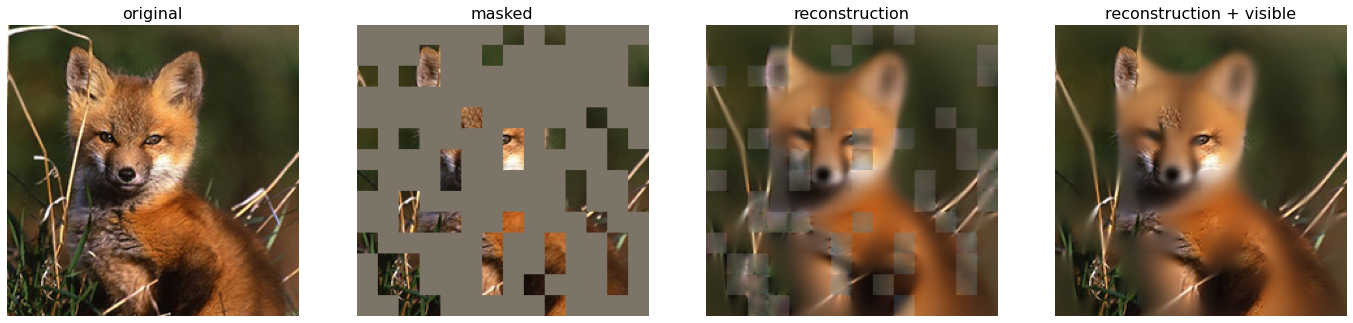

In [8]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae)

### Load another pre-trained MAE model

In [9]:
# This is an MAE model trained with an extra GAN loss for more realistic generation (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_base_ganloss.pth
# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth
# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_huge_ganloss.pth

chkpt_dir = 'mae_visualize_vit_large_ganloss.pth'
model_mae_gan = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')

--2023-09-11 22:11:26--  https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_base_ganloss.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.156.201.129, 108.156.201.112, 108.156.201.23, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.156.201.129|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2023-09-11 22:11:26 ERROR 403: Forbidden.

--2023-09-11 22:11:27--  https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.156.201.112, 108.156.201.23, 108.156.201.76, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.156.201.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1318315181 (1.2G) [binary/octet-stream]
Saving to: ‘mae_visualize_vit_large_ganloss.pth’

mae_visualize_vit_l 100%[===================>]   1.23G  79.8MB/s    in 15s     

2023-09-11 22:11:42 (82.3 MB/s) - ‘mae_visu

### Run MAE on the image

MAE with extra GAN loss:


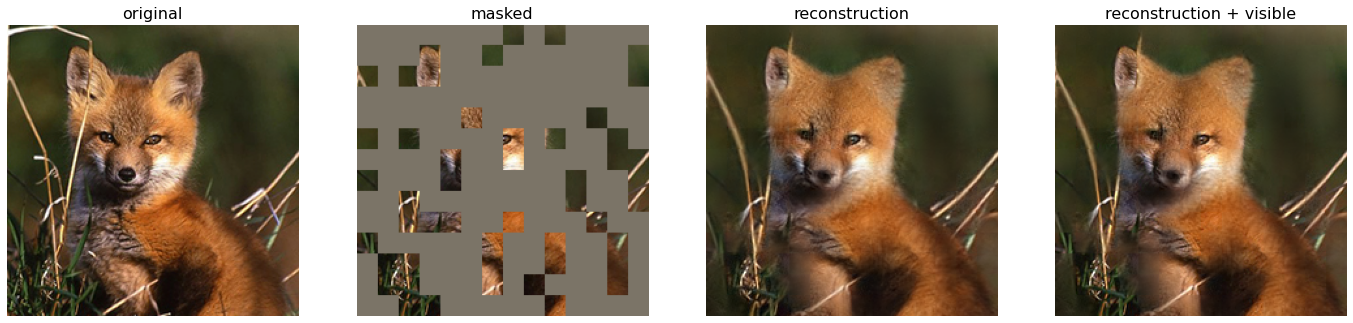

In [9]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with extra GAN loss:')
run_one_image(img, model_mae_gan)

### Run MAE on Cervix

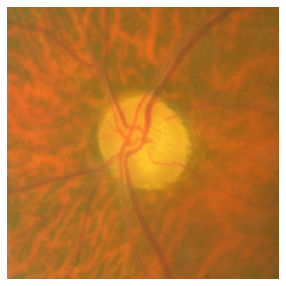

In [10]:
# image_path = '/projects/Cervical_Cancer_Projects/data/full_dataset_duke_liger_itoju_5StLowQual/6_0000008.jpg'
# image_path = '/projects/Cervical_Cancer_Projects/data/full_dataset_duke_liger_itoju_5StLowQual/1_0000147.jpg'
# image_path = '/projects/Cervical_Cancer_Projects/data/full_dataset_duke_liger_itoju_5StLowQual/PUBL00033374.jpg'
# image_path = '/projects/Cervical_Cancer_Projects/data/full_dataset_duke_liger_itoju_5StLowQual/ZRQB-00000505.jpg'
image_path = '/projects/Fundus_Segmentation/Organized_Datasets/Riga_Organized/Cropped/Prime/MagrabiaMale_image1-4.png'
img = Image.open(image_path)
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

MAE with extra GAN loss:


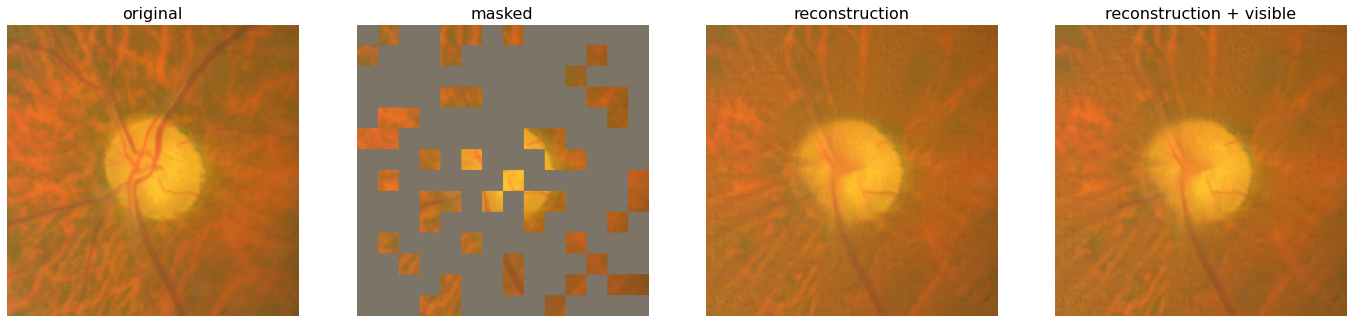

In [11]:
# make random mask reproducible (comment out to make it change)
# torch.manual_seed(2)
print('MAE with extra GAN loss:')
run_one_image(img, model_mae_gan)

# From HuggingFace

https://github.com/NielsRogge/Transformers-Tutorials/blob/master/ViTMAE/ViT_MAE_visualization_demo.ipynb

2023-09-06 22:45:56.626837: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/projects/Cervical_Cancer_Projects/transformers/src/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


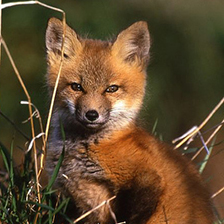

In [12]:
from transformers import ViTFeatureExtractor
import requests
from PIL import Image

feature_extractor = ViTFeatureExtractor.from_pretrained("facebook/vit-mae-base")
url = "https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image

In [13]:
pixel_values = feature_extractor(image, return_tensors="pt").pixel_values

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt

imagenet_mean = np.array(feature_extractor.image_mean)
imagenet_std = np.array(feature_extractor.image_std)

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def visualize(pixel_values, model):
    # forward pass
    outputs = model(pixel_values)
    y = model.unpatchify(outputs.logits)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()
    
    # visualize the mask
    mask = outputs.mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.config.patch_size**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', pixel_values)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


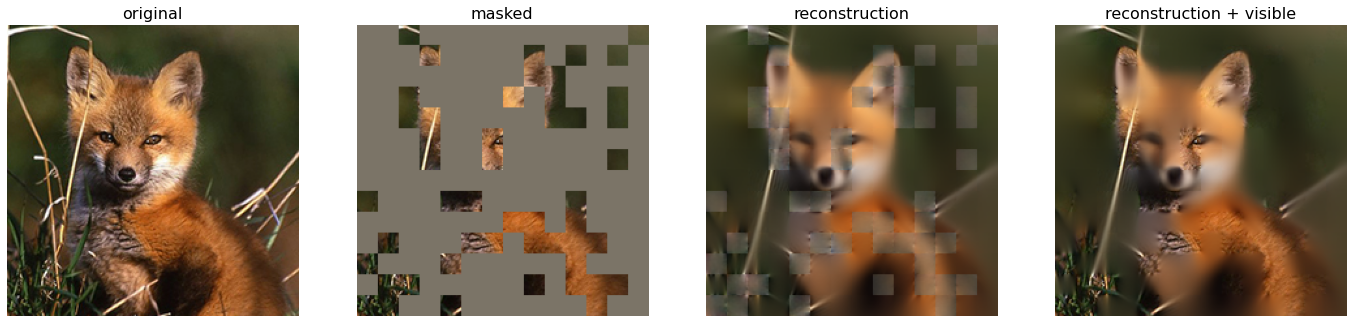

In [15]:
from transformers import ViTMAEForPreTraining

# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)

model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")

visualize(pixel_values, model)

In [16]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained("facebook/vit-mae-base")

You are using a model of type vit_mae to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/vit-mae-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Experimenting with loading in the models

In [19]:
# Models and architectures

facebook_model = "facebook/vit-mae-base"
facebook_model_large = "facebook/vit-mae-large"
google_model = 'google/vit-base-patch16-224-in21k'
gan_loss_weights = '/projects/Cervical_Cancer_Projects/SSL/mae_facebook/demo/mae_visualize_vit_large_ganloss.pth'
gan_loss_arch = 'mae_vit_large_patch16'

## From .from_pretrained

In [20]:
# .from_pretrained

model_facebook = ViTMAEForPreTraining.from_pretrained(facebook_model)
print(model_facebook.config)
print(model_facebook)

ViTMAEConfig {
  "_name_or_path": "facebook/vit-mae-base",
  "architectures": [
    "ViTMAEForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.0,
  "decoder_hidden_size": 512,
  "decoder_intermediate_size": 2048,
  "decoder_num_attention_heads": 16,
  "decoder_num_hidden_layers": 8,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "mask_ratio": 0.75,
  "model_type": "vit_mae",
  "norm_pix_loss": false,
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.32.0.dev0"
}

ViTMAEForPreTraining(
  (vit): ViTMAEModel(
    (embeddings): ViTMAEEmbeddings(
      (patch_embeddings): ViTMAEPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
    )
    (encoder): ViTMAEEncoder(
      (layer): Mo

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


So, we see that the Google and Facebook come with their own config file, which gives us the architecture, and they come with weights. They also have the config file for the preprocessing.

In [17]:
from transformers import ViTFeatureExtractor

facebook_feature_extractor = ViTFeatureExtractor.from_pretrained(facebook_model)
print(f'Facebook feature extractor {facebook_feature_extractor}')

google_feature_extractor = ViTFeatureExtractor.from_pretrained(google_model)
print(f'Google feature extractor {google_feature_extractor}')

Facebook feature extractor ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

Google feature extractor ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



/projects/Cervical_Cancer_Projects/transformers/src/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


# From prepare_model

In [18]:
# from prepare_model

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

In [19]:
model_mae_gan = prepare_model(gan_loss_weights, gan_loss_arch)
print(model_mae_gan.config)

<All keys matched successfully>


AttributeError: 'MaskedAutoencoderViT' object has no attribute 'config'

In [20]:
print(model_mae_gan)

MaskedAutoencoderViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate=none)
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop2):

In [21]:
'''
So, the prepare_model function is calling from the models_mae:

def mae_vit_base_patch16_dec512d8b(**kwargs):
    model = MaskedAutoencoderViT(
        patch_size=16, embed_dim=768, depth=12, num_heads=12,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def mae_vit_large_patch16_dec512d8b(**kwargs):
    model = MaskedAutoencoderViT(
        patch_size=16, embed_dim=1024, depth=24, num_heads=16,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def mae_vit_huge_patch14_dec512d8b(**kwargs):
    model = MaskedAutoencoderViT(
        patch_size=14, embed_dim=1280, depth=32, num_heads=16,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


# set recommended archs
mae_vit_base_patch16 = mae_vit_base_patch16_dec512d8b  # decoder: 512 dim, 8 blocks
mae_vit_large_patch16 = mae_vit_large_patch16_dec512d8b  # decoder: 512 dim, 8 blocks
mae_vit_huge_patch14 = mae_vit_huge_patch14_dec512d8b  # decoder: 512 dim, 8 blocks

Using this method, we DO NOT have a config file
'''

'\nSo, the prepare_model function is calling from the models_mae:\n\ndef mae_vit_base_patch16_dec512d8b(**kwargs):\n    model = MaskedAutoencoderViT(\n        patch_size=16, embed_dim=768, depth=12, num_heads=12,\n        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,\n        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)\n    return model\n\n\ndef mae_vit_large_patch16_dec512d8b(**kwargs):\n    model = MaskedAutoencoderViT(\n        patch_size=16, embed_dim=1024, depth=24, num_heads=16,\n        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,\n        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)\n    return model\n\n\ndef mae_vit_huge_patch14_dec512d8b(**kwargs):\n    model = MaskedAutoencoderViT(\n        patch_size=14, embed_dim=1280, depth=32, num_heads=16,\n        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,\n        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)\n    retu

## From output of run_mae

In [22]:
from transformers import ViTMAEConfig

full_path = '/projects/Cervical_Cancer_Projects/SSL/hf_mae/outputs_8_16'
config_from_run_mae = '/projects/Cervical_Cancer_Projects/SSL/hf_mae/outputs_8_16/config.json'
model_from_run_mae = '/projects/Cervical_Cancer_Projects/SSL/hf_mae/outputs_8_16/pytorch_model.bin'

from_run_mae_config = ViTMAEConfig.from_pretrained(config_from_run_mae)
print(from_run_mae_config)

ViTMAEConfig {
  "_name_or_path": "facebook/vit-mae-base",
  "architectures": [
    "ViTMAEForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.0,
  "decoder_hidden_size": 512,
  "decoder_intermediate_size": 2048,
  "decoder_num_attention_heads": 16,
  "decoder_num_hidden_layers": 8,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "mask_ratio": 0.75,
  "model_type": "vit_mae",
  "norm_pix_loss": true,
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.32.0.dev0"
}



In [23]:
# Just loading in the outputs of the run_mae

from_run_mae_model = ViTMAEForPreTraining.from_pretrained(full_path)
print(from_run_mae_model.config)
print(from_run_mae_model)

ViTMAEConfig {
  "_name_or_path": "/projects/Cervical_Cancer_Projects/SSL/hf_mae/outputs_8_16",
  "architectures": [
    "ViTMAEForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.0,
  "decoder_hidden_size": 512,
  "decoder_intermediate_size": 2048,
  "decoder_num_attention_heads": 16,
  "decoder_num_hidden_layers": 8,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "mask_ratio": 0.75,
  "model_type": "vit_mae",
  "norm_pix_loss": true,
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.32.0.dev0"
}

ViTMAEForPreTraining(
  (vit): ViTMAEModel(
    (embeddings): ViTMAEEmbeddings(
      (patch_embeddings): ViTMAEPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
    )
    (encode

In [24]:
# Loading in the config and the weights separately

model = ViTMAEForPreTraining.from_pretrained(model_from_run_mae, config = config_from_run_mae)
model

ViTMAEForPreTraining(
  (vit): ViTMAEModel(
    (embeddings): ViTMAEEmbeddings(
      (patch_embeddings): ViTMAEPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
    )
    (encoder): ViTMAEEncoder(
      (layer): ModuleList(
        (0): ViTMAELayer(
          (attention): ViTMAEAttention(
            (attention): ViTMAESelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTMAESelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTMAEIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)

In [25]:
# Loading in the weights with the facebook config file

model = ViTMAEForPreTraining.from_pretrained(model_from_run_mae, config = model_facebook.config)
model

ViTMAEForPreTraining(
  (vit): ViTMAEModel(
    (embeddings): ViTMAEEmbeddings(
      (patch_embeddings): ViTMAEPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
    )
    (encoder): ViTMAEEncoder(
      (layer): ModuleList(
        (0): ViTMAELayer(
          (attention): ViTMAEAttention(
            (attention): ViTMAESelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTMAESelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTMAEIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)

In [26]:
# Loading in the GAN-loss weights with the config from the run_mae

model = ViTMAEForPreTraining.from_pretrained(gan_loss_weights, config = config_from_run_mae)
model

Some weights of the model checkpoint at /projects/Cervical_Cancer_Projects/SSL/mae_facebook/demo/mae_visualize_vit_large_ganloss.pth were not used when initializing ViTMAEForPreTraining: ['model']
- This IS expected if you are initializing ViTMAEForPreTraining from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTMAEForPreTraining from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTMAEForPreTraining were not initialized from the model checkpoint at /projects/Cervical_Cancer_Projects/SSL/mae_facebook/demo/mae_visualize_vit_large_ganloss.pth and are newly initialized: ['decoder.decoder_layers.4.output.dense.bias', 'decoder.decoder_norm.bias', 'decoder.decoder_embed.bias', 'encoder.layer.

ViTMAEForPreTraining(
  (vit): ViTMAEModel(
    (embeddings): ViTMAEEmbeddings(
      (patch_embeddings): ViTMAEPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
    )
    (encoder): ViTMAEEncoder(
      (layer): ModuleList(
        (0): ViTMAELayer(
          (attention): ViTMAEAttention(
            (attention): ViTMAESelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTMAESelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTMAEIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)

In [21]:
# Loading in the GAN-loss weights with the config from facebook 

model_facebook_large = ViTMAEForPreTraining.from_pretrained(facebook_model_large)
facebook_model_large_config_file = model_facebook_large.config
model = ViTMAEForPreTraining.from_pretrained(gan_loss_weights, config = facebook_model_large_config_file)
model

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
Some weights of the model checkpoint at /projects/Cervical_Cancer_Projects/SSL/mae_facebook/demo/mae_visualize_vit_large_ganloss.pth were not used when initializing ViTMAEForPreTraining: ['model']
- This IS expected if you are initializing ViTMAEForPreTraining from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTMAEForPreTraining from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification m

ViTMAEForPreTraining(
  (vit): ViTMAEModel(
    (embeddings): ViTMAEEmbeddings(
      (patch_embeddings): ViTMAEPatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      )
    )
    (encoder): ViTMAEEncoder(
      (layer): ModuleList(
        (0): ViTMAELayer(
          (attention): ViTMAEAttention(
            (attention): ViTMAESelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTMAESelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTMAEIntermediate(
            (dense): Linear(in_features=1024, out_features=4096, 

# Mixing

In [25]:
from transformers import ViTMAEForPreTraining

# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)

model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")
checkpoint = torch.load(gan_loss_weights, map_location='cpu')
msg = model.load_state_dict(checkpoint['model'], strict=False)
print(msg)

_IncompatibleKeys(missing_keys=['vit.embeddings.cls_token', 'vit.embeddings.position_embeddings', 'vit.embeddings.patch_embeddings.projection.weight', 'vit.embeddings.patch_embeddings.projection.bias', 'vit.encoder.layer.0.attention.attention.query.weight', 'vit.encoder.layer.0.attention.attention.query.bias', 'vit.encoder.layer.0.attention.attention.key.weight', 'vit.encoder.layer.0.attention.attention.key.bias', 'vit.encoder.layer.0.attention.attention.value.weight', 'vit.encoder.layer.0.attention.attention.value.bias', 'vit.encoder.layer.0.attention.output.dense.weight', 'vit.encoder.layer.0.attention.output.dense.bias', 'vit.encoder.layer.0.intermediate.dense.weight', 'vit.encoder.layer.0.intermediate.dense.bias', 'vit.encoder.layer.0.output.dense.weight', 'vit.encoder.layer.0.output.dense.bias', 'vit.encoder.layer.0.layernorm_before.weight', 'vit.encoder.layer.0.layernorm_before.bias', 'vit.encoder.layer.0.layernorm_after.weight', 'vit.encoder.layer.0.layernorm_after.bias', 'vit.e

So, it seems as if the facebook architecture is slightly different, and we can't load in all the weights. We checked this with base, large, and huge.

# Classification Testing

In [28]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(google_model)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
